## Import packages

In [1]:
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from config import opt
from models import DenoiserMNISTModel
from utils import get_dataloaders, train_autoencoder_model, show_tensor_images, init_seeds
from datasets.preprocessing import train_disc_transformations, val_disc_transformations, train_autoencoder_transformations, val_autoencoder_transformations, target_transform

In [4]:
init_seeds(opt.seed)

## Prepare dataset

In [5]:
train_autoencoder_loader, val_autoencoder_loader, _, _ = get_dataloaders(
    train_disc_transformations, val_disc_transformations, train_autoencoder_transformations, val_autoencoder_transformations, target_transform
)

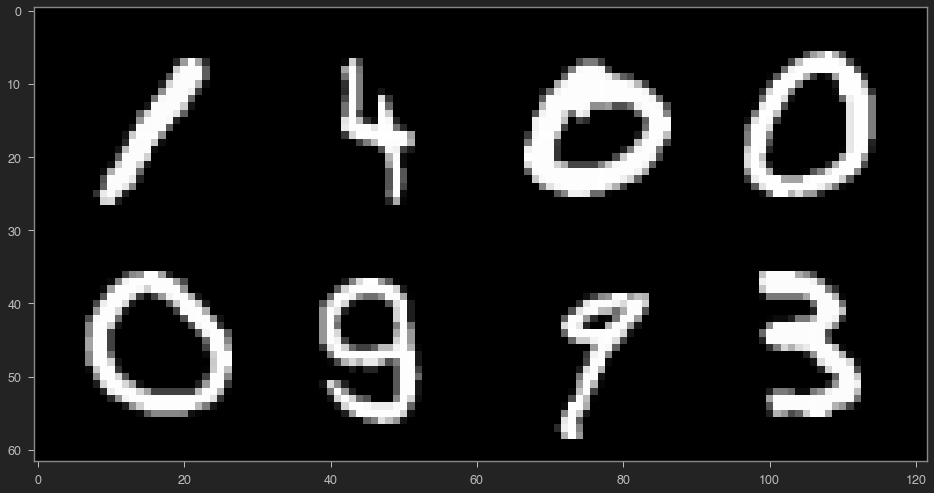

In [6]:
show_tensor_images(next(iter(val_autoencoder_loader))[0], norm_mean=opt.norm_mean, norm_std=opt.norm_std)

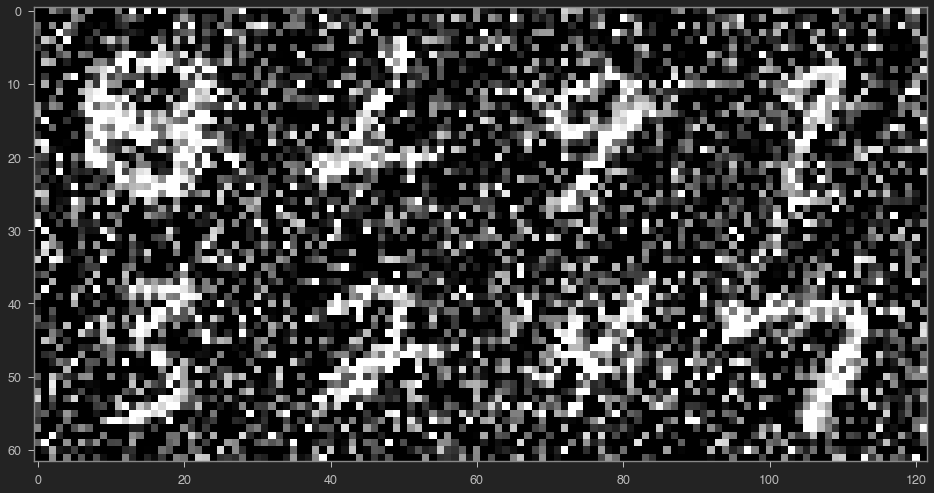

In [7]:
show_tensor_images(next(iter(val_autoencoder_loader))[0], norm_mean=opt.norm_mean, norm_std=opt.norm_std, add_noise=True)

In [8]:
len(next(iter(val_autoencoder_loader))), next(iter(val_autoencoder_loader))[-1].shape, next(iter(val_autoencoder_loader))[0].shape

(2, torch.Size([128, 10]), torch.Size([128, 1, 28, 28]))

## Training

In [9]:
input_dim = (1, opt.img_height, opt.img_width)

model = DenoiserMNISTModel(
    input_dim[0], opt.autoencoder_hidden_channels, opt.encoder_out_channels
).to(opt.device)

criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=opt.lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

In [10]:
summary(model, input_size=input_dim, batch_size=opt.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 14, 14]             272
       BatchNorm2d-2          [128, 16, 14, 14]              32
         LeakyReLU-3          [128, 16, 14, 14]               0
            Conv2d-4            [128, 32, 7, 7]           8,224
       BatchNorm2d-5            [128, 32, 7, 7]              64
         LeakyReLU-6            [128, 32, 7, 7]               0
            Conv2d-7            [128, 64, 3, 3]          32,832
       BatchNorm2d-8            [128, 64, 3, 3]             128
         LeakyReLU-9            [128, 64, 3, 3]               0
           Conv2d-10           [128, 128, 1, 1]         131,200
          Encoder-11           [128, 128, 1, 1]               0
  ConvTranspose2d-12            [128, 64, 3, 3]         131,136
      BatchNorm2d-13            [128, 64, 3, 3]             128
        LeakyReLU-14            [128, 6

In [11]:
train_autoencoder_model(model, optimizer, scheduler, criterion, train_autoencoder_loader, val_autoencoder_loader, opt, target_metric='loss_avg', best_target_metric=np.inf)

Train Epoch: [0][  0/235]	Time  5.364 ( 5.364)	Data  1.460 ( 1.460)	Loss 3.1290e-01 (3.1290e-01)
Train Epoch: [0][ 10/235]	Time  0.187 ( 0.734)	Data  0.001 ( 0.134)	Loss 2.4602e-01 (2.7607e-01)
Train Epoch: [0][ 20/235]	Time  0.202 ( 0.481)	Data  0.001 ( 0.070)	Loss 2.1955e-01 (2.5509e-01)
Train Epoch: [0][ 30/235]	Time  0.173 ( 0.388)	Data  0.001 ( 0.048)	Loss 2.0672e-01 (2.4165e-01)
Train Epoch: [0][ 40/235]	Time  0.352 ( 0.349)	Data  0.001 ( 0.036)	Loss 1.9137e-01 (2.3104e-01)
Train Epoch: [0][ 50/235]	Time  0.182 ( 0.321)	Data  0.001 ( 0.029)	Loss 1.8070e-01 (2.2209e-01)
Train Epoch: [0][ 60/235]	Time  0.208 ( 0.307)	Data  0.001 ( 0.025)	Loss 1.6867e-01 (2.1417e-01)
Train Epoch: [0][ 70/235]	Time  0.217 ( 0.297)	Data  0.001 ( 0.021)	Loss 1.5755e-01 (2.0703e-01)
Train Epoch: [0][ 80/235]	Time  0.244 ( 0.297)	Data  0.001 ( 0.019)	Loss 1.4963e-01 (2.0048e-01)
Train Epoch: [0][ 90/235]	Time  0.186 ( 0.286)	Data  0.001 ( 0.017)	Loss 1.4132e-01 (1.9442e-01)
Train Epoch: [0][100/235]	Time

## Inference

In [12]:
from torchvision.datasets import MNIST
from utils.loops import infer_autoencoder_one_image

In [13]:
model = DenoiserMNISTModel(
    input_dim[0], opt.autoencoder_hidden_channels, opt.encoder_out_channels
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{model.__class__.__name__}_model_best.pth'))
model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

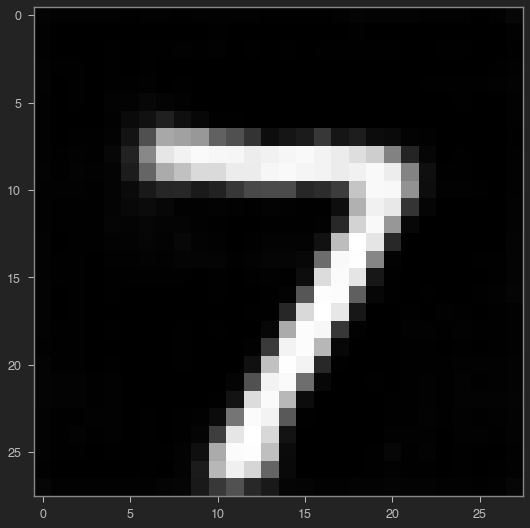

In [14]:
infer_autoencoder_dataset = MNIST(
    opt.path_to_data / 'mnist', download=True, train=False,
)

image = next(iter(infer_autoencoder_dataset))[0]
target = next(iter(infer_autoencoder_dataset))[1]
predicted = infer_autoencoder_one_image(
    image, model, opt.device, transform=val_autoencoder_transformations,
)

show_tensor_images(predicted, norm_mean=opt.norm_mean, norm_std=opt.norm_std)